In this notebook, we are going to implement a graph coloring algorithm based on a MIS solver for a practical problem of sharing a bandwidth of frequencies for a network of antennas.

In [7]:
# imports
from mis import MISSolver, SolverConfig
import networkx as nx
import sys
sys.path.append('../')
from datasets import dataloader
import matplotlib.pyplot as plt


## Importing our dataset

The practical dataset of interest is the placement of 5G antennas in Paris that can be found in the `antenna_Paris.csv` file. A set of antennas are distributed over the city with a specific coverage range. Therefore, some antennas will be in range of each other.

In [2]:
loader = dataloader.DataLoader()
loader.load_from_csv_coordinates('./antenna_Paris.csv')

## Representing our problem instance
- We will represent the problem by a graph, such that each node represents an antenna, with an edge between two if they are in the range of each other. We consider that all the antennas have a constant range R, which we will set to $1.2km$.

In [3]:
instance = loader.build_mis_instance_from_coordinates(1.2)

Let's visualize our dataset :

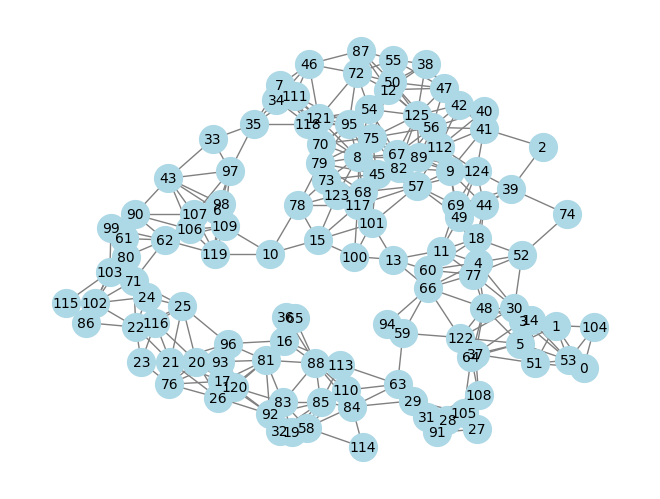

In [4]:
pos = {i: (loader.coordinates_dataset[i][1], loader.coordinates_dataset[i][0]) for i in range(len(loader.coordinates_dataset))}
nx.draw(instance.graph, pos, with_labels=True, node_size=400, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')


## Solving the RMP Problem
We will use the greedy heuristic algorithm described in [Appendix A](https://arxiv.org/pdf/2301.02637) to find a coloring of the graph using MIS output at each iteration.

Notice that we test our algorithm on the first 100 antennas of the dataset.

In [13]:
class GraphColoringSolver:
    def __init__(self, loader : dataloader.DataLoader, antenna_range : float):
        self.loader = loader
        self.antenna_range = antenna_range

    def solve(self):
        antennas = set([x for x in range(len(loader.coordinates_dataset))])
        self.colors = [-1]*len(antennas)

        color = 0
        while len(antennas) > 0:
            solver = MISSolver(loader.build_mis_instance_from_coordinates(self.antenna_range, antennas), SolverConfig())
            solutions = solver.solve().result()
            for antenna in solutions[0].nodes:
                self.colors[antenna] = color
            antennas = antennas - set(solutions[0].nodes)
            color += 1
        return self.colors

    def visualize_solution(self):
        plt.figure(figsize=(10, 8))
        for i, (lat, lon) in enumerate(self.loader.coordinates_dataset):
            plt.scatter(lon, lat, c=f'C{self.colors[i]}', label=f'Antenna {i}' if self.colors[i] == 0 else "", s=100)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Antenna Coverage Solution')
        plt.grid()
        plt.show()
    

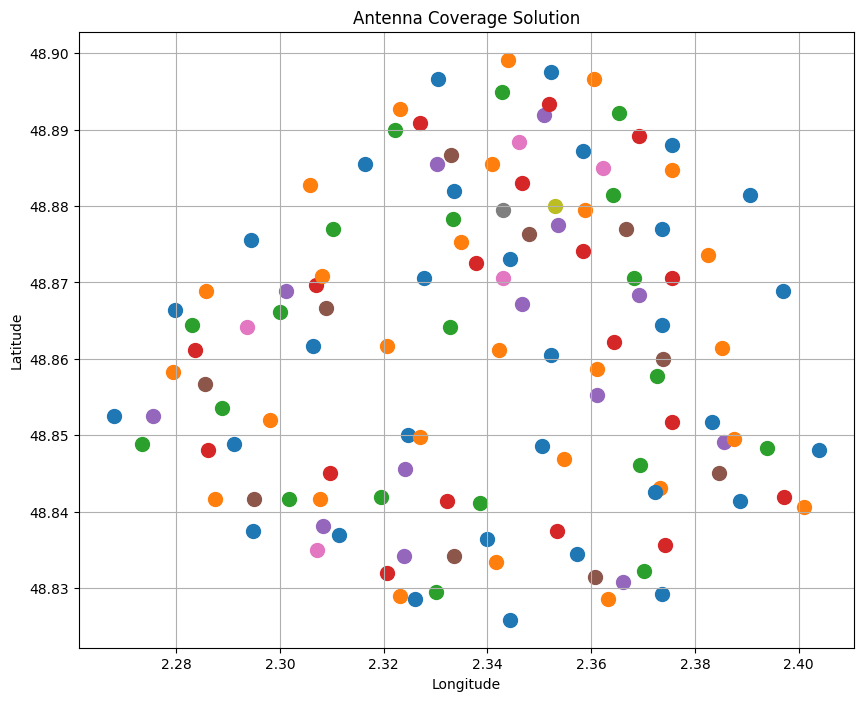

[1, 2, 0, 4, 5, 5, 3, 1, 7, 5, 1, 3, 4, 0, 1, 2, 4, 4, 0, 0, 2, 5, 3, 1, 2, 1, 6, 0, 4, 0, 0, 5, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 3, 0, 3, 5, 0, 2, 3, 4, 3, 0, 1, 3, 6, 0, 6, 3, 2, 1, 1, 2, 6, 3, 0, 1, 4, 8, 0, 2, 0, 5, 2, 1, 0, 3, 0, 2, 0, 2, 3, 2, 4, 4, 1, 5, 2, 1, 3, 1, 1, 1, 3, 1, 0, 1, 3, 2, 1, 0, 1, 4, 4, 1, 0, 2, 2, 4, 3, 5, 0, 3, 2, 2, 0, 0, 0, 6, 4, 0, 0, 5, 2, 3, 0, 0]
Number of colors used: 9


In [14]:
solver = GraphColoringSolver(loader, 1.2)
colors = solver.solve()
solver.visualize_solution()
print(colors)
print(f"Number of colors used: {max(colors)+1}")